In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from jupyterthemes import jtplot 
jtplot.style(theme="monokai", context="notebook", ticks=True)

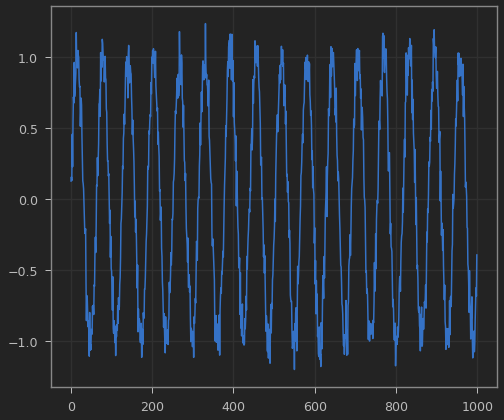

In [2]:
# Create synthetic data
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

plt.plot(series)
plt.show()

In [3]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    
    y = series[t+T]
    Y.append(y)
    
    
X = np.asarray(X)
Y = np.asarray(Y)

X = X.reshape(-1, T, 1)
Y = Y.reshape(-1 , 1)
N = len(X)

print("Shape of X : {} || Y : {}".format(X.shape, Y.shape))

Shape of X : (990, 10, 1) || Y : (990, 1)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


In [5]:
# Define the RNN Model

class SimpleRNN(nn.Module):
    
    def __init__(self, n_inputs, n_hidden, n_layers, n_outputs):
        
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.L = n_layers
        self.K = n_outputs
        
        
        self.rnn = nn.RNN(input_size=self.D, hidden_size=self.M, 
                         num_layers = self.L, nonlinearity='relu', 
                         batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self, X):
        
        # initial hidden state
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        
        return out
        
        

In [6]:
model = SimpleRNN(n_inputs=1, n_hidden=5, n_layers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [8]:
# Make inputs and targets 
Xtrain = torch.from_numpy(X[:-N//2].astype(np.float32))
Ytrain = torch.from_numpy(Y[:-N//2].astype(np.float32))

Xtest = torch.from_numpy(X[-N//2:].astype(np.float32))
Ytest = torch.from_numpy(Y[-N//2:].astype(np.float32))


In [9]:
Xtrain, Ytrain, Xtest, Ytest = Xtrain.to(device), Ytrain.to(device), Xtest.to(device), Ytest.to(device)

In [10]:
def full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=20):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # zero the optimizer gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(Xtrain)
        loss = criterion(outputs, Ytrain)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Track the losses
        train_losses[epoch] = loss
        
        
        # Test data
        testoutputs = model(Xtest)
        testloss = criterion(testoutputs, Ytest)
        test_losses[epoch] = testloss
        
        if (epoch + 1) % 5 == 0:
            print("Epoch : {}/ {} || Train Loss : {:.4f} || Test Loss : {:.4f}".format(epoch + 1, epochs,
                                                                                      train_losses[epoch],
                                                                                      test_losses[epoch]))
            
            
    return train_losses, test_losses

In [11]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=200)

Epoch : 5/ 200 || Train Loss : 0.6255 || Test Loss : 0.6184
Epoch : 10/ 200 || Train Loss : 0.5442 || Test Loss : 0.5430
Epoch : 15/ 200 || Train Loss : 0.5105 || Test Loss : 0.5217
Epoch : 20/ 200 || Train Loss : 0.5184 || Test Loss : 0.5332
Epoch : 25/ 200 || Train Loss : 0.5188 || Test Loss : 0.5296
Epoch : 30/ 200 || Train Loss : 0.5105 || Test Loss : 0.5217
Epoch : 35/ 200 || Train Loss : 0.5115 || Test Loss : 0.5229
Epoch : 40/ 200 || Train Loss : 0.5120 || Test Loss : 0.5225
Epoch : 45/ 200 || Train Loss : 0.5101 || Test Loss : 0.5215
Epoch : 50/ 200 || Train Loss : 0.5105 || Test Loss : 0.5224
Epoch : 55/ 200 || Train Loss : 0.5104 || Test Loss : 0.5220
Epoch : 60/ 200 || Train Loss : 0.5100 || Test Loss : 0.5214
Epoch : 65/ 200 || Train Loss : 0.5102 || Test Loss : 0.5215
Epoch : 70/ 200 || Train Loss : 0.5100 || Test Loss : 0.5215
Epoch : 75/ 200 || Train Loss : 0.5100 || Test Loss : 0.5216
Epoch : 80/ 200 || Train Loss : 0.5100 || Test Loss : 0.5216
Epoch : 85/ 200 || Train 

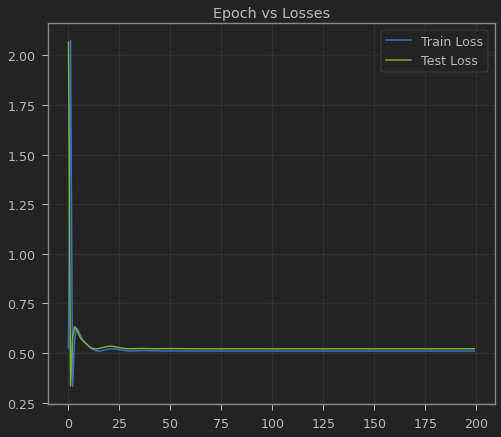

In [12]:
plt.title("Epoch vs Losses")
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend()
plt.show()

In [13]:
# Forecast future values
validation_target = Y[-N//2:]
validation_predictions = []

last_x = Xtest[0].view(T)

while len(validation_predictions) < len(validation_target):
    
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))
    

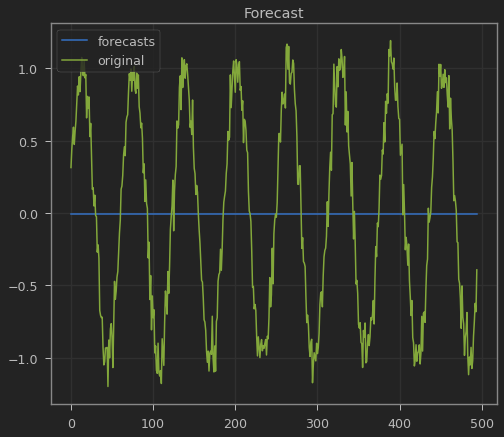

In [14]:
plt.title("Forecast")
plt.plot(validation_predictions, label="forecasts")
plt.plot(validation_target, label="original")
plt.legend()
plt.show()